In [41]:
# -*- coding: utf-8 -*-
# HW07.ipynb

# ============================================
# Импорт библиотек и настройки
# ============================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, adjusted_rand_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import json
import os
import warnings
warnings.filterwarnings('ignore')

# Настройки для воспроизводимости
np.random.seed(42)
plt.style.use('seaborn-v0_8-darkgrid')

# Создание папок для артефактов
os.makedirs('artifacts/figures', exist_ok=True)
os.makedirs('artifacts/labels', exist_ok=True)

# Словарь для хранения результатов
all_results = {}

In [42]:
# ============================================
# Вспомогательные функции для анализа
# ============================================
def load_and_analyze_dataset(file_path, dataset_name):
    """Загрузка и базовый анализ датасета"""
    print(f"\n{'='*60}")
    print(f"ДАТАСЕТ: {dataset_name}")
    print(f"{'='*60}")

    # Загрузка данных
    df = pd.read_csv(file_path)

    # Основная информация
    print(f"Размер: {df.shape[0]} строк, {df.shape[1]} столбцов")
    print(f"Столбцы: {list(df.columns)}")

    # Разделение на признаки и идентификатор
    sample_id = df['sample_id']
    X = df.drop('sample_id', axis=1)

    # Анализ типов данных
    print("\nТипы данных:")
    print(X.dtypes.value_counts())

    # Пропущенные значения
    missing = X.isnull().sum()
    if missing.sum() > 0:
        print("\nПропущенные значения:")
        for col, count in missing[missing > 0].items():
            print(f"  {col}: {count} ({count/len(X)*100:.1f}%)")
    else:
        print("\nПропущенных значений нет")

    # Базовые статистики для числовых признаков
    print("\nОсновные статистики:")
    print(X.describe().round(2))

    return df, X, sample_id

def preprocess_data(X, dataset_name):
    """Препроцессинг данных"""
    print(f"\nПрепроцессинг для {dataset_name}:")

    # Проверяем типы признаков
    numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

    print(f"  Числовые признаки: {len(numeric_cols)}")
    print(f"  Категориальные признаки: {len(categorical_cols)}")

    # Препроцессинг
    if len(categorical_cols) == 0:
        # Только числовые признаки
        pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ])
        X_processed = pipeline.fit_transform(X)
        print("  Применен: SimpleImputer + StandardScaler")
    else:
        # Есть категориальные признаки
        numeric_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ])

        categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ])

        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, numeric_cols),
                ('cat', categorical_transformer, categorical_cols)
            ])

        X_processed = preprocessor.fit_transform(X)
        print("  Применен: ColumnTransformer с OneHotEncoder для категориальных признаков")

    return X_processed

def apply_kmeans(X_scaled, dataset_name):
    """Применение KMeans с подбором оптимального k"""
    print(f"\nKMeans для {dataset_name}:")

    # Диапазон значений k для тестирования
    k_range = range(2, 21)
    silhouette_scores = []
    db_scores = []
    ch_scores = []

    best_k = 0
    best_silhouette = -1

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X_scaled)

        # Расчет метрик
        if len(np.unique(labels)) > 1:  # silhouette требует как минимум 2 кластера
            sil_score = silhouette_score(X_scaled, labels)
            db_score = davies_bouldin_score(X_scaled, labels)
            ch_score = calinski_harabasz_score(X_scaled, labels)

            silhouette_scores.append(sil_score)
            db_scores.append(db_score)
            ch_scores.append(ch_score)

            # Сохранение лучшего k по silhouette
            if sil_score > best_silhouette:
                best_silhouette = sil_score
                best_k = k
                best_labels = labels
                best_kmeans = kmeans

    # Визуализация результатов
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    axes[0].plot(k_range, silhouette_scores, marker='o', color='blue')
    axes[0].axvline(x=best_k, color='red', linestyle='--', alpha=0.7)
    axes[0].set_xlabel('Число кластеров (k)')
    axes[0].set_ylabel('Silhouette Score')
    axes[0].set_title(f'KMeans: Silhouette Score\nЛучшее k = {best_k}')
    axes[0].grid(True, alpha=0.3)

    axes[1].plot(k_range, db_scores, marker='o', color='green')
    axes[1].axvline(x=best_k, color='red', linestyle='--', alpha=0.7)
    axes[1].set_xlabel('Число кластеров (k)')
    axes[1].set_ylabel('Davies-Bouldin Score')
    axes[1].set_title('Davies-Bouldin Score (меньше = лучше)')
    axes[1].grid(True, alpha=0.3)

    axes[2].plot(k_range, ch_scores, marker='o', color='purple')
    axes[2].axvline(x=best_k, color='red', linestyle='--', alpha=0.7)
    axes[2].set_xlabel('Число кластеров (k)')
    axes[2].set_ylabel('Calinski-Harabasz Score')
    axes[2].set_title('Calinski-Harabasz Score (больше = лучше)')
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'artifacts/figures/{dataset_name}_kmetrics.png', dpi=100, bbox_inches='tight')
    plt.show()

    print(f"  Лучшее k по silhouette: {best_k}")
    print(f"  Silhouette score: {best_silhouette:.3f}")
    print(f"  Davies-Bouldin score: {davies_bouldin_score(X_scaled, best_labels):.3f}")
    print(f"  Calinski-Harabasz score: {calinski_harabasz_score(X_scaled, best_labels):.3f}")

    return best_kmeans, best_labels, best_k

def apply_dbscan(X_scaled, dataset_name):
    """Применение DBSCAN с подбором параметров"""
    print(f"\nDBSCAN для {dataset_name}:")

    # Тестируем различные значения eps
    eps_values = [0.1, 0.2, 0.3, 0.5, 0.7, 1.0, 1.5, 2.0]
    min_samples_values = [3, 5, 10, 15]

    best_eps = 0
    best_min_samples = 0
    best_silhouette = -1
    best_labels = None
    best_dbscan = None

    results = []

    for eps in eps_values:
        for min_samples in min_samples_values:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(X_scaled)

            # Проверяем количество кластеров (без учета шума)
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

            if n_clusters > 1:  # silhouette требует как минимум 2 кластера
                # Используем только точки не-шум для расчета silhouette
                non_noise_mask = labels != -1
                if np.sum(non_noise_mask) > 1:
                    sil_score = silhouette_score(X_scaled[non_noise_mask], labels[non_noise_mask])
                else:
                    sil_score = -1
            else:
                sil_score = -1

            noise_ratio = np.sum(labels == -1) / len(labels)

            results.append({
                'eps': eps,
                'min_samples': min_samples,
                'silhouette': sil_score,
                'n_clusters': n_clusters,
                'noise_ratio': noise_ratio
            })

            if sil_score > best_silhouette:
                best_silhouette = sil_score
                best_eps = eps
                best_min_samples = min_samples
                best_labels = labels
                best_dbscan = dbscan

    # Создаем таблицу результатов
    results_df = pd.DataFrame(results)
    pivot_table = results_df.pivot_table(index='eps', columns='min_samples', values='silhouette')

    # Визуализация heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot_table, annot=True, fmt='.3f', cmap='YlOrRd',
                cbar_kws={'label': 'Silhouette Score'})
    plt.title(f'DBSCAN: Silhouette Score для разных параметров\n{dataset_name}')
    plt.xlabel('min_samples')
    plt.ylabel('eps')
    plt.savefig(f'artifacts/figures/{dataset_name}_dbscan_heatmap.png', dpi=100, bbox_inches='tight')
    plt.show()

    print(f"  Лучшие параметры: eps={best_eps}, min_samples={best_min_samples}")
    print(f"  Silhouette score: {best_silhouette:.3f}")

    if best_labels is not None:
        noise_mask = best_labels == -1
        noise_ratio = np.sum(noise_mask) / len(best_labels)
        print(f"  Доля шума: {noise_ratio:.3f} ({np.sum(noise_mask)} точек)")
        print(f"  Количество кластеров: {len(set(best_labels)) - (1 if -1 in best_labels else 0)}")

        # Расчет метрик на не-шуме
        non_noise_mask = best_labels != -1
        if np.sum(non_noise_mask) > 1:
            print(f"  Davies-Bouldin (non-noise): {davies_bouldin_score(X_scaled[non_noise_mask], best_labels[non_noise_mask]):.3f}")
            print(f"  Calinski-Harabasz (non-noise): {calinski_harabasz_score(X_scaled[non_noise_mask], best_labels[non_noise_mask]):.3f}")

    return best_dbscan, best_labels

def visualize_clusters(X_scaled, labels, dataset_name, method_name):
    """Визуализация кластеров с помощью PCA"""
    print(f"\nВизуализация PCA для {dataset_name} ({method_name}):")

    # PCA для визуализации
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X_scaled)

    # Объясненная дисперсия
    explained_var = pca.explained_variance_ratio_
    print(f"  Объясненная дисперсия PCA: {explained_var[0]:.3f} + {explained_var[1]:.3f} = {sum(explained_var):.3f}")

    # Создание scatter plot
    plt.figure(figsize=(12, 8))

    # Создаем цветовую схему
    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)

    # Отдельно отображаем шум (-1) серым цветом
    if -1 in labels:
        noise_mask = labels == -1
        plt.scatter(X_pca[noise_mask, 0], X_pca[noise_mask, 1],
                   c='gray', alpha=0.3, s=20, label='Шум', marker='x')

    # Отображаем кластеры
    for label in unique_labels:
        if label != -1:
            mask = labels == label
            plt.scatter(X_pca[mask, 0], X_pca[mask, 1],
                       alpha=0.6, s=30, label=f'Кластер {label}')

    plt.xlabel(f'PCA Component 1 ({explained_var[0]*100:.1f}%)')
    plt.ylabel(f'PCA Component 2 ({explained_var[1]*100:.1f}%)')
    plt.title(f'PCA визуализация: {dataset_name}\n{method_name}, {n_clusters} кластеров')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Сохранение
    filename = f'artifacts/figures/{dataset_name}_pca_{method_name.lower()}.png'
    plt.savefig(filename, dpi=100, bbox_inches='tight')
    plt.show()

    # t-SNE опционально (только для небольших датасетов)
    if X_scaled.shape[0] < 5000:
        try:
            tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
            X_tsne = tsne.fit_transform(X_scaled[:1000])  # ограничиваем выборку для скорости

            plt.figure(figsize=(12, 8))
            unique_labels_tsne = np.unique(labels[:1000])

            if -1 in labels[:1000]:
                noise_mask = labels[:1000] == -1
                plt.scatter(X_tsne[noise_mask, 0], X_tsne[noise_mask, 1],
                           c='gray', alpha=0.3, s=20, label='Шум', marker='x')

            for label in unique_labels_tsne:
                if label != -1:
                    mask = labels[:1000] == label
                    plt.scatter(X_tsne[mask, 0], X_tsne[mask, 1],
                               alpha=0.6, s=30, label=f'Кластер {label}')

            plt.xlabel('t-SNE Component 1')
            plt.ylabel('t-SNE Component 2')
            plt.title(f't-SNE визуализация: {dataset_name}\n{method_name} (первые 1000 точек)')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.savefig(f'artifacts/figures/{dataset_name}_tsne_{method_name.lower()}.png', dpi=100, bbox_inches='tight')
            plt.show()
        except Exception as e:
            print(f"  t-SNE пропущен из-за ошибки или большого объема данных: {e}")

    return X_pca

def stability_check(X_scaled, dataset_name):
    """Проверка устойчивости KMeans"""
    print(f"\nПроверка устойчивости для {dataset_name}:")

    # Определяем оптимальное k
    k_range = range(2, 11)
    silhouette_scores = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X_scaled)
        # Ensure there are at least two unique labels for silhouette_score
        if len(np.unique(labels)) > 1:
            silhouette_scores.append(silhouette_score(X_scaled, labels))
        else:
            silhouette_scores.append(-1) # Penalize single-cluster results

    if not silhouette_scores or max(silhouette_scores) <= 0:
        print("  Не удалось определить оптимальное k или Silhouette Score слишком низкий. Пропуск проверки устойчивости.")
        return 0.0

    optimal_k = k_range[np.argmax(silhouette_scores)]
    print(f"  Оптимальное k: {optimal_k}")

    # Запускаем KMeans 5 раз с разными random_state
    ari_scores = []
    labels_list = []

    for i in range(5):
        kmeans = KMeans(n_clusters=optimal_k, random_state=i*10, n_init=10)
        labels = kmeans.fit_predict(X_scaled)
        labels_list.append(labels)

    # Вычисляем ARI между всеми парами
    for i in range(5):
        for j in range(i+1, 5):
            ari = adjusted_rand_score(labels_list[i], labels_list[j])
            ari_scores.append(ari)

    # Визуализация
    plt.figure(figsize=(10, 6))
    plt.boxplot(ari_scores)
    plt.scatter(np.ones_like(ari_scores), ari_scores, alpha=0.6, s=50)
    plt.axhline(y=np.mean(ari_scores), color='r', linestyle='--', label=f'Среднее: {np.mean(ari_scores):.3f}')
    plt.xlabel('Параметры')
    plt.ylabel('Adjusted Rand Index (ARI)')
    plt.title(f'Проверка устойчивости KMeans\n{dataset_name}, k={optimal_k}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(f'artifacts/figures/{dataset_name}_stability_check.png', dpi=100, bbox_inches='tight')
    plt.show()

    print(f"  Средний ARI: {np.mean(ari_scores):.3f}")
    print(f"  Стандартное отклонение ARI: {np.std(ari_scores):.3f}")
    print(f"  Устойчивость: {'Высокая' if np.mean(ari_scores) > 0.9 else 'Средняя' if np.mean(ari_scores) > 0.7 else 'Низкая'}")

    return np.mean(ari_scores)


ДАТАСЕТ: dataset1
Размер: 12000 строк, 9 столбцов
Столбцы: ['sample_id', 'f01', 'f02', 'f03', 'f04', 'f05', 'f06', 'f07', 'f08']

Типы данных:
float64    8
Name: count, dtype: int64

Пропущенных значений нет

Основные статистики:
            f01       f02       f03       f04       f05       f06       f07  \
count  12000.00  12000.00  12000.00  12000.00  12000.00  12000.00  12000.00   
mean      -2.42     19.11     -0.22     -8.28     -0.19      0.96      0.03   
std       11.01     60.79      0.50     59.27      7.03     14.79     59.54   
min      -19.91    -92.89     -1.59   -134.30    -11.87    -20.52   -215.10   
25%       -9.47    -40.28     -0.13    -48.35     -5.13     -8.81    -39.90   
50%       -6.87     54.07     -0.03     16.21      0.44     -6.13     -0.58   
75%        0.52     70.28      0.05     28.07      3.94      2.33     39.72   
max       24.40    112.23      0.51     75.09     13.72     41.45    213.38   

            f08  
count  12000.00  
mean       0.01  
std

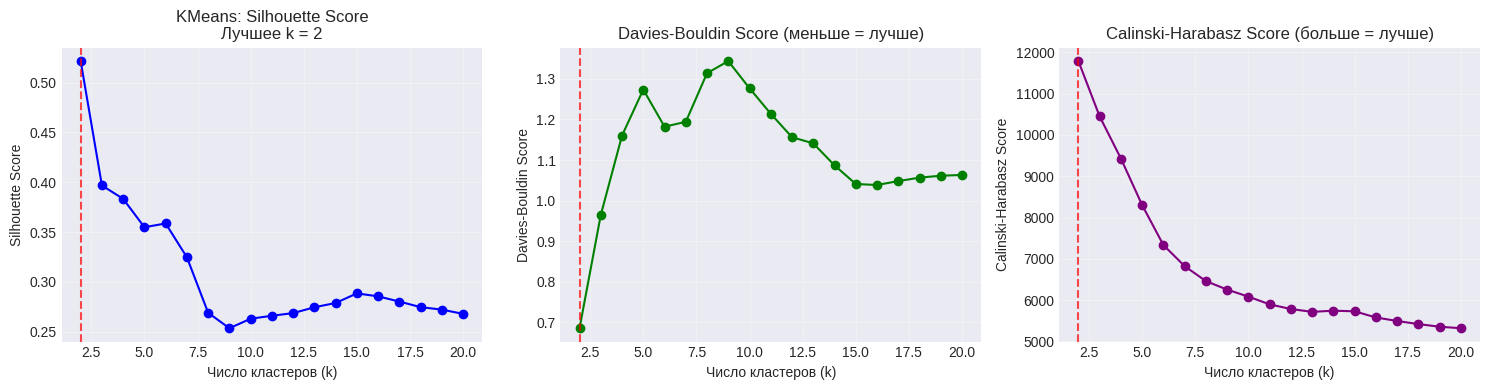

  Лучшее k по silhouette: 2
  Silhouette score: 0.522
  Davies-Bouldin score: 0.685
  Calinski-Harabasz score: 11786.955

DBSCAN для dataset1:


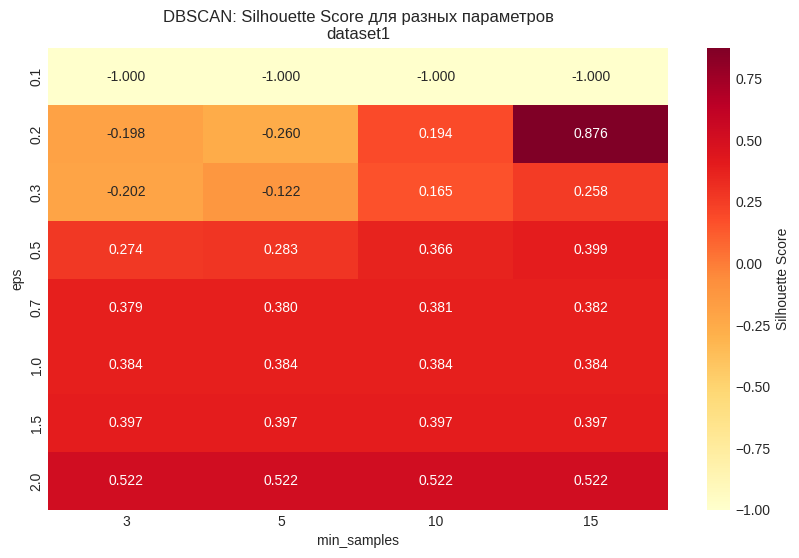

  Лучшие параметры: eps=0.2, min_samples=15
  Silhouette score: 0.876
  Доля шума: 0.997 (11963 точек)
  Количество кластеров: 2
  Davies-Bouldin (non-noise): 0.170
  Calinski-Harabasz (non-noise): 1091.657

Визуализация PCA для dataset1 (KMeans):
  Объясненная дисперсия PCA: 0.546 + 0.143 = 0.689


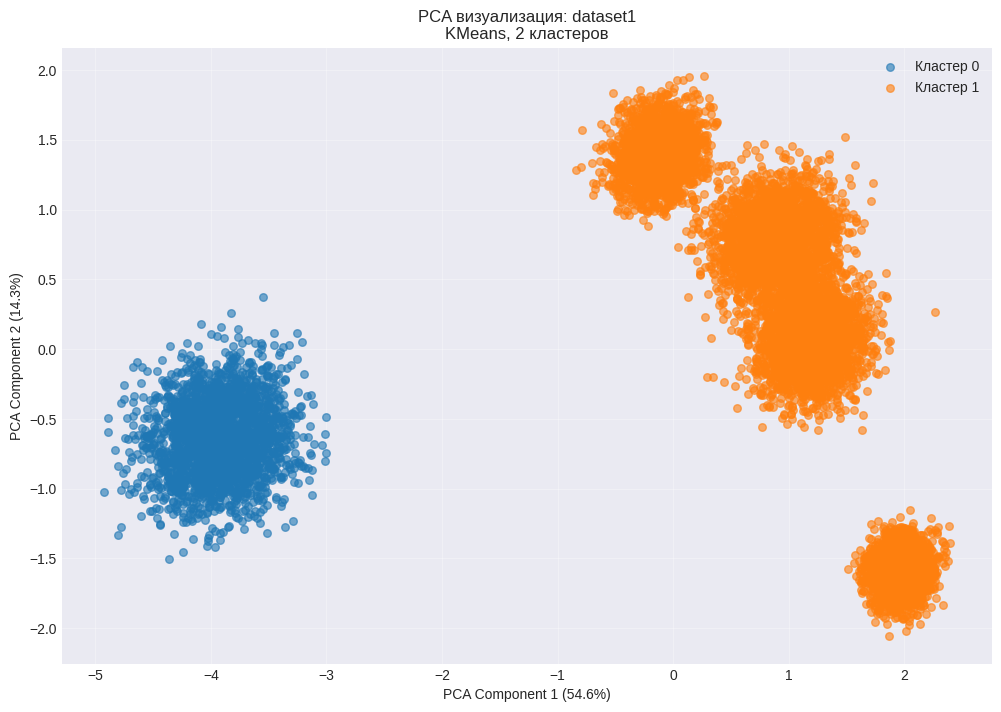


Визуализация PCA для dataset1 (DBSCAN):
  Объясненная дисперсия PCA: 0.546 + 0.143 = 0.689


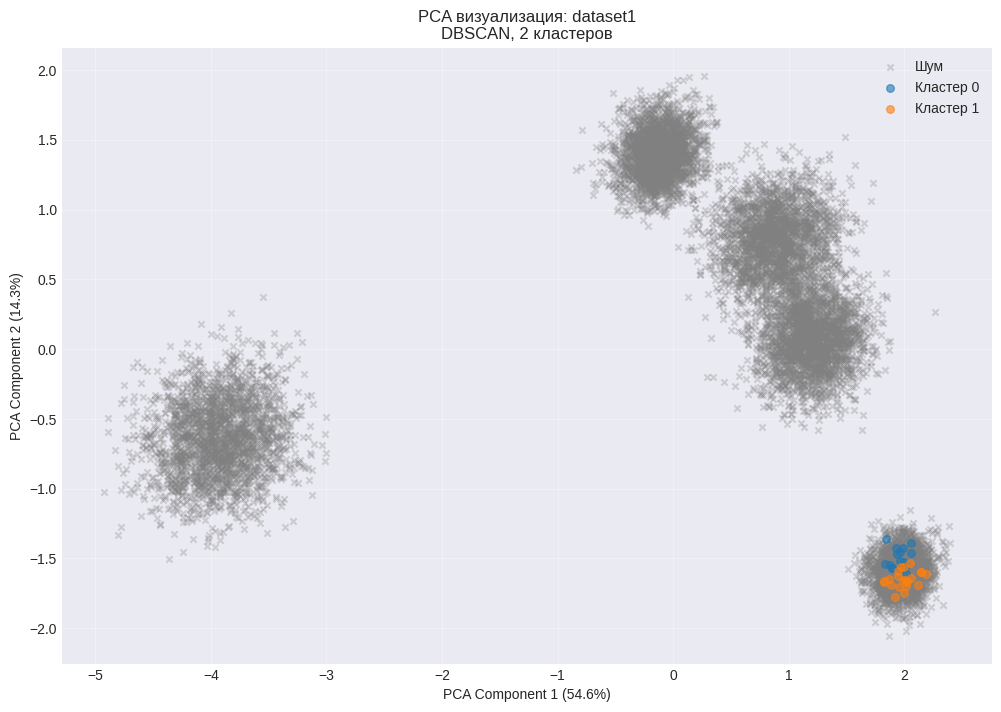

In [43]:
# ============================================
# АНАЛИЗ ДАТАСЕТА 1: S07-hw-dataset-01.csv
# ============================================
dataset1_name = "dataset1"
df1, X1, sample_id1 = load_and_analyze_dataset('data/S07-hw-dataset-01.csv', dataset1_name)
X1_processed = preprocess_data(X1, dataset1_name)

# Применяем KMeans
kmeans1, kmeans_labels1, best_k1 = apply_kmeans(X1_processed, dataset1_name)

# Применяем DBSCAN
dbscan1, dbscan_labels1 = apply_dbscan(X1_processed, dataset1_name)

# Визуализация PCA
pca_kmeans1 = visualize_clusters(X1_processed, kmeans_labels1, dataset1_name, "KMeans")
pca_dbscan1 = visualize_clusters(X1_processed, dbscan_labels1, dataset1_name, "DBSCAN")

# Сохранение результатов для dataset1
all_results[dataset1_name] = {
    'KMeans': {
        'labels': kmeans_labels1,
        'k': best_k1,
        'silhouette': silhouette_score(X1_processed, kmeans_labels1),
        'davies_bouldin': davies_bouldin_score(X1_processed, kmeans_labels1),
        'calinski_harabasz': calinski_harabasz_score(X1_processed, kmeans_labels1)
    },
    'DBSCAN': {
        'labels': dbscan_labels1,
        'n_clusters': len(set(dbscan_labels1)) - (1 if -1 in dbscan_labels1 else 0),
        'noise_ratio': np.sum(dbscan_labels1 == -1) / len(dbscan_labels1),
        'silhouette': silhouette_score(X1_processed[dbscan_labels1 != -1],
                                       dbscan_labels1[dbscan_labels1 != -1]) if np.sum(dbscan_labels1 != -1) > 1 else -1,
        'davies_bouldin': davies_bouldin_score(X1_processed[dbscan_labels1 != -1],
                                                dbscan_labels1[dbscan_labels1 != -1]) if np.sum(dbscan_labels1 != -1) > 1 else -1,
        'calinski_harabasz': calinski_harabasz_score(X1_processed[dbscan_labels1 != -1],
                                                     dbscan_labels1[dbscan_labels1 != -1]) if np.sum(dbscan_labels1 != -1) > 1 else -1
    }
}


ДАТАСЕТ: dataset2
Размер: 8000 строк, 4 столбцов
Столбцы: ['sample_id', 'x1', 'x2', 'z_noise']

Типы данных:
float64    3
Name: count, dtype: int64

Пропущенных значений нет

Основные статистики:
            x1       x2  z_noise
count  8000.00  8000.00  8000.00
mean      0.48     0.24     0.11
std       0.96     0.66     8.10
min      -2.49    -2.50   -34.06
25%      -0.12    -0.24    -5.39
50%       0.49     0.24     0.13
75%       1.09     0.73     5.66
max       2.99     3.00    29.46

Препроцессинг для dataset2:
  Числовые признаки: 3
  Категориальные признаки: 0
  Применен: SimpleImputer + StandardScaler

KMeans для dataset2:


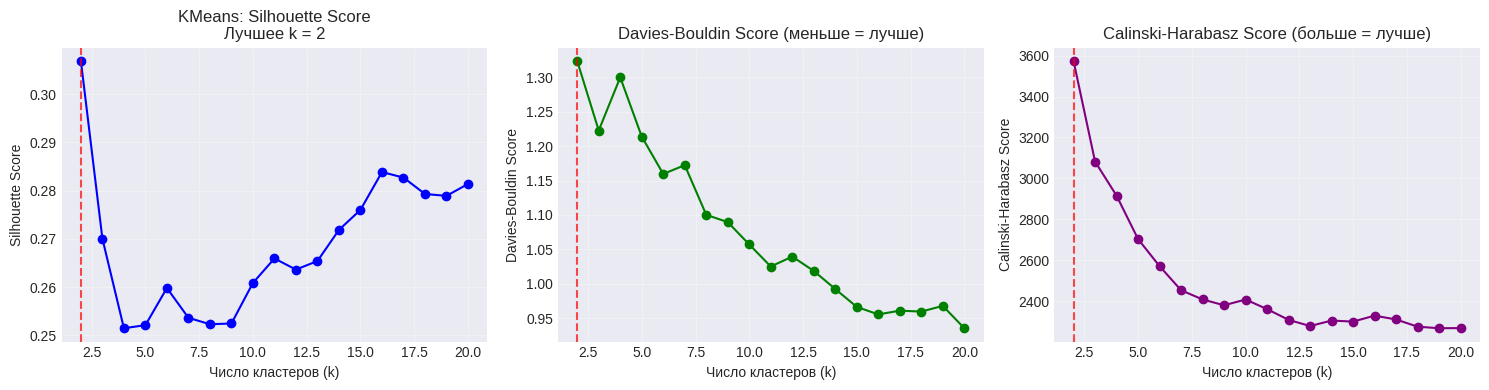

  Лучшее k по silhouette: 2
  Silhouette score: 0.307
  Davies-Bouldin score: 1.323
  Calinski-Harabasz score: 3573.393

DBSCAN для dataset2:


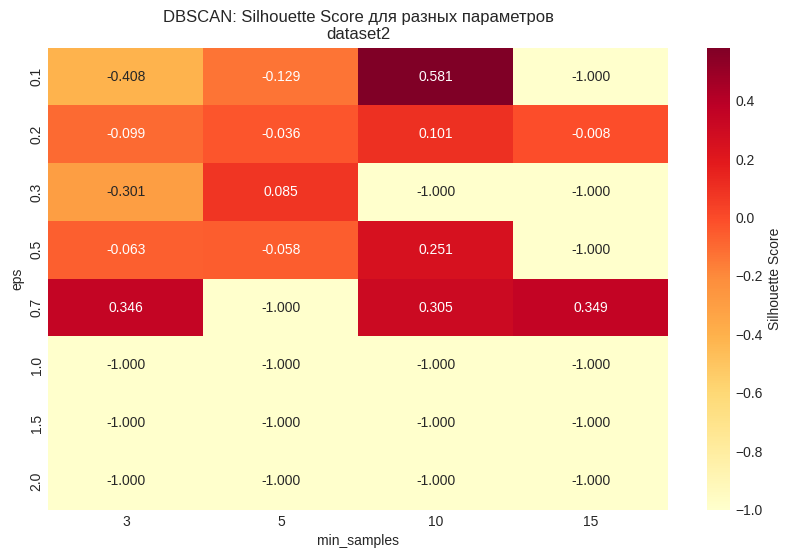

  Лучшие параметры: eps=0.1, min_samples=10
  Silhouette score: 0.581
  Доля шума: 0.918 (7348 точек)
  Количество кластеров: 46
  Davies-Bouldin (non-noise): 0.578
  Calinski-Harabasz (non-noise): 2758.123

Визуализация PCA для dataset2 (KMeans):
  Объясненная дисперсия PCA: 0.425 + 0.334 = 0.759


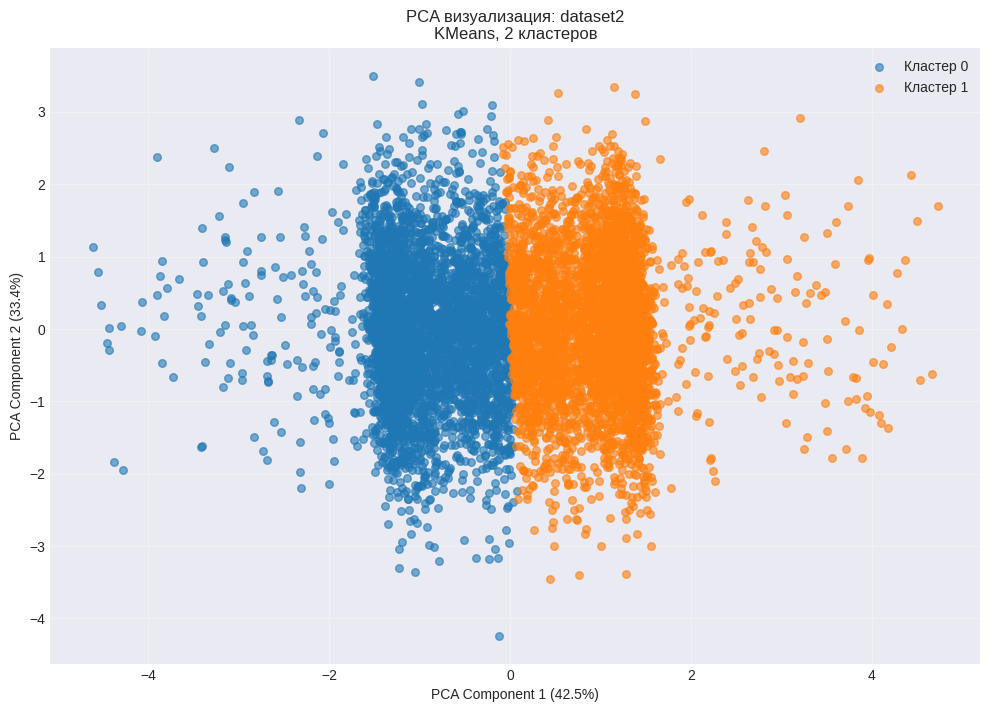


Визуализация PCA для dataset2 (DBSCAN):
  Объясненная дисперсия PCA: 0.425 + 0.334 = 0.759


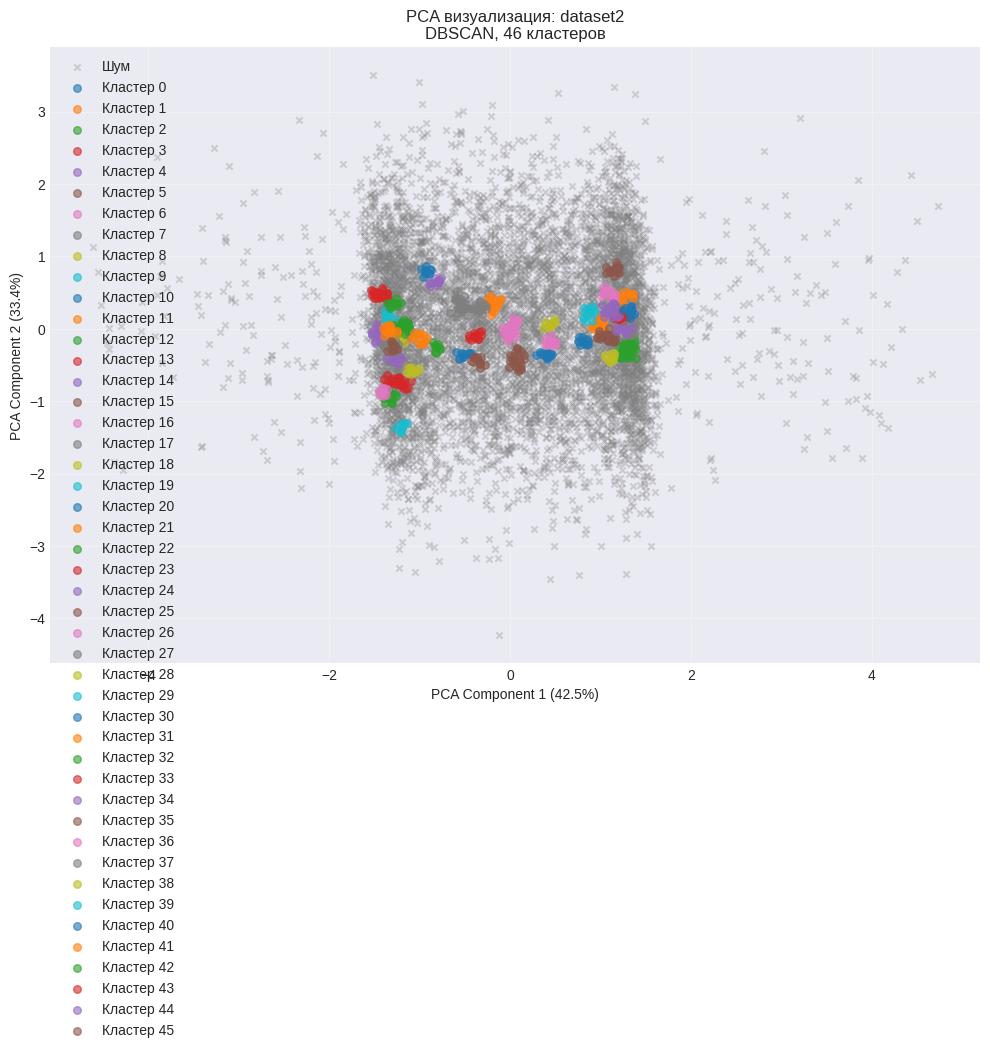

In [44]:
# ============================================
# АНАЛИЗ ДАТАСЕТА 2: S07-hw-dataset-02.csv
# ============================================
dataset2_name = "dataset2"
df2, X2, sample_id2 = load_and_analyze_dataset('data/S07-hw-dataset-02.csv', dataset2_name)
X2_processed = preprocess_data(X2, dataset2_name)

# Применяем KMeans
kmeans2, kmeans_labels2, best_k2 = apply_kmeans(X2_processed, dataset2_name)

# Применяем DBSCAN
dbscan2, dbscan_labels2 = apply_dbscan(X2_processed, dataset2_name)

# Визуализация PCA
pca_kmeans2 = visualize_clusters(X2_processed, kmeans_labels2, dataset2_name, "KMeans")
pca_dbscan2 = visualize_clusters(X2_processed, dbscan_labels2, dataset2_name, "DBSCAN")

# Сохранение результатов для dataset2
all_results[dataset2_name] = {
    'KMeans': {
        'labels': kmeans_labels2,
        'k': best_k2,
        'silhouette': silhouette_score(X2_processed, kmeans_labels2),
        'davies_bouldin': davies_bouldin_score(X2_processed, kmeans_labels2),
        'calinski_harabasz': calinski_harabasz_score(X2_processed, kmeans_labels2)
    },
    'DBSCAN': {
        'labels': dbscan_labels2,
        'n_clusters': len(set(dbscan_labels2)) - (1 if -1 in dbscan_labels2 else 0),
        'noise_ratio': np.sum(dbscan_labels2 == -1) / len(dbscan_labels2),
        'silhouette': silhouette_score(X2_processed[dbscan_labels2 != -1],
                                       dbscan_labels2[dbscan_labels2 != -1]) if np.sum(dbscan_labels2 != -1) > 1 else -1,
        'davies_bouldin': davies_bouldin_score(X2_processed[dbscan_labels2 != -1],
                                                dbscan_labels2[dbscan_labels2 != -1]) if np.sum(dbscan_labels2 != -1) > 1 else -1,
        'calinski_harabasz': calinski_harabasz_score(X2_processed[dbscan_labels2 != -1],
                                                     dbscan_labels2[dbscan_labels2 != -1]) if np.sum(dbscan_labels2 != -1) > 1 else -1
    }
}


ДАТАСЕТ: dataset3
Размер: 15000 строк, 5 столбцов
Столбцы: ['sample_id', 'x1', 'x2', 'f_corr', 'f_noise']

Типы данных:
float64    4
Name: count, dtype: int64

Пропущенных значений нет

Основные статистики:
             x1        x2    f_corr   f_noise
count  15000.00  15000.00  15000.00  15000.00
mean       1.25      1.03      0.21     -0.03
std        4.59      4.71      1.53      2.51
min      -10.00     -9.98     -5.21     -8.79
25%       -1.78     -2.67     -0.97     -1.73
50%        0.66      1.83      0.30     -0.05
75%        4.44      4.97      1.39      1.67
max       16.21     14.27      5.80     11.27

Препроцессинг для dataset3:
  Числовые признаки: 4
  Категориальные признаки: 0
  Применен: SimpleImputer + StandardScaler

KMeans для dataset3:


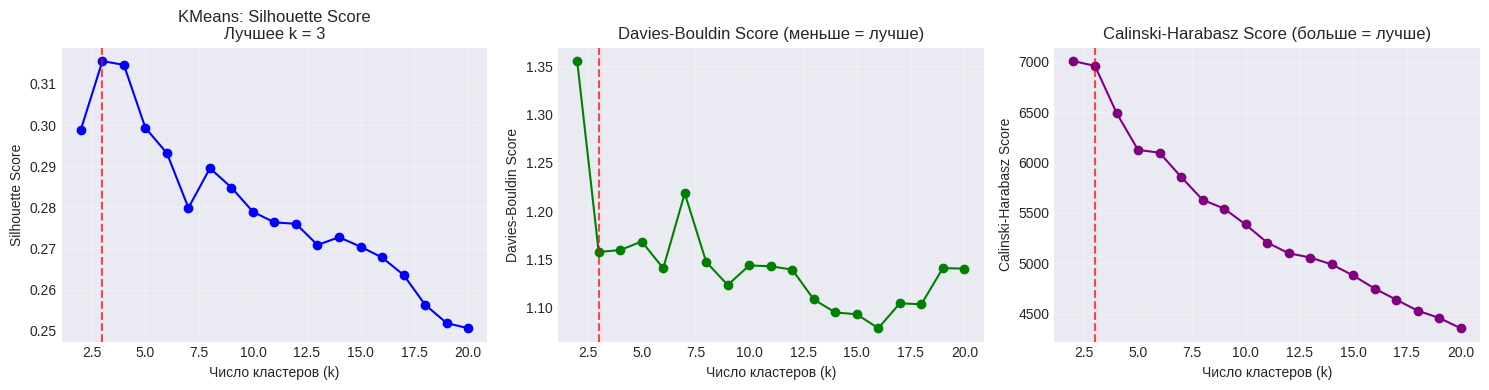

  Лучшее k по silhouette: 3
  Silhouette score: 0.316
  Davies-Bouldin score: 1.158
  Calinski-Harabasz score: 6957.163

DBSCAN для dataset3:


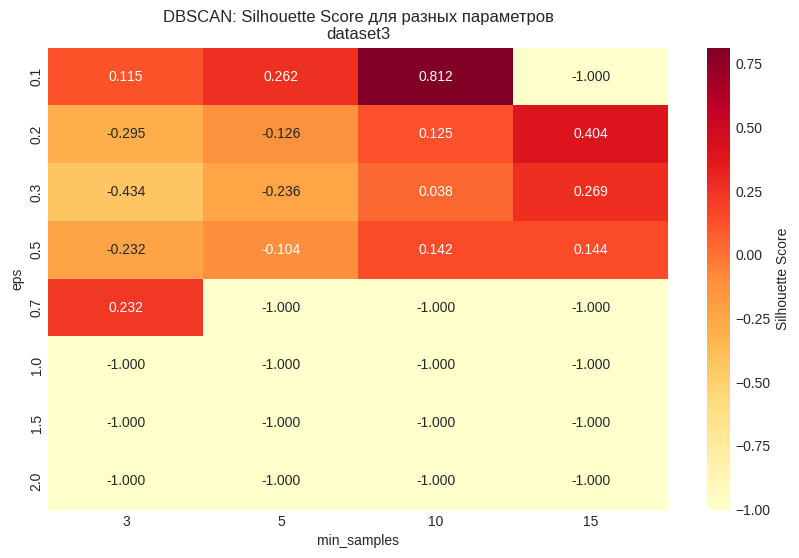

  Лучшие параметры: eps=0.1, min_samples=10
  Silhouette score: 0.812
  Доля шума: 0.996 (14939 точек)
  Количество кластеров: 5
  Davies-Bouldin (non-noise): 0.245
  Calinski-Harabasz (non-noise): 3564.021

Визуализация PCA для dataset3 (KMeans):
  Объясненная дисперсия PCA: 0.442 + 0.278 = 0.719


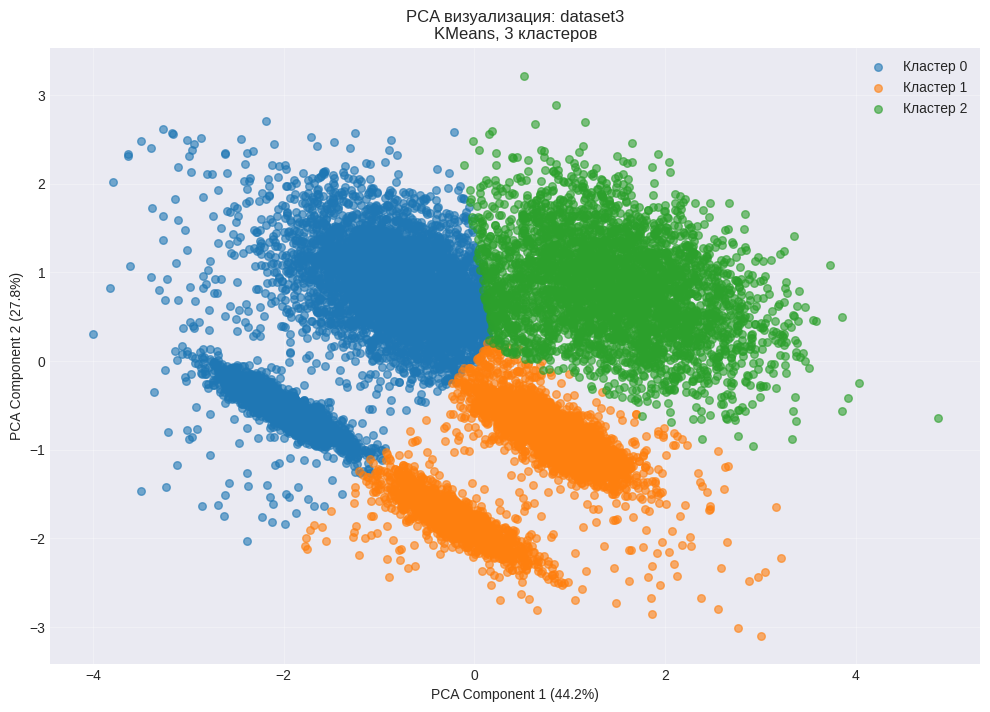


Визуализация PCA для dataset3 (DBSCAN):
  Объясненная дисперсия PCA: 0.442 + 0.278 = 0.719


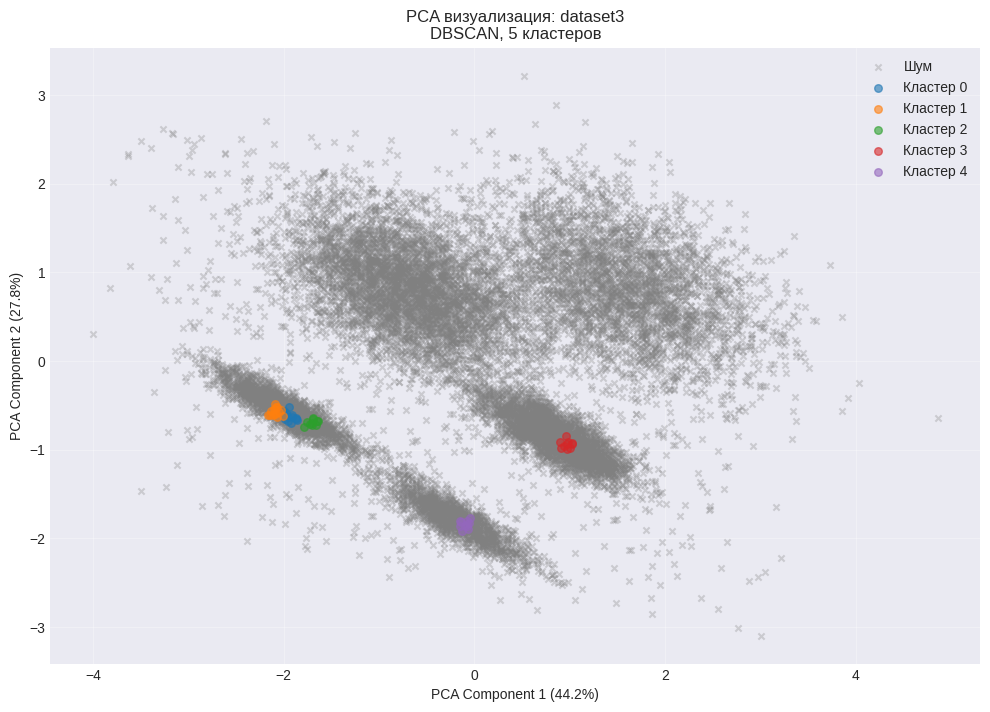


Проверка устойчивости для dataset3:
  Оптимальное k: 3


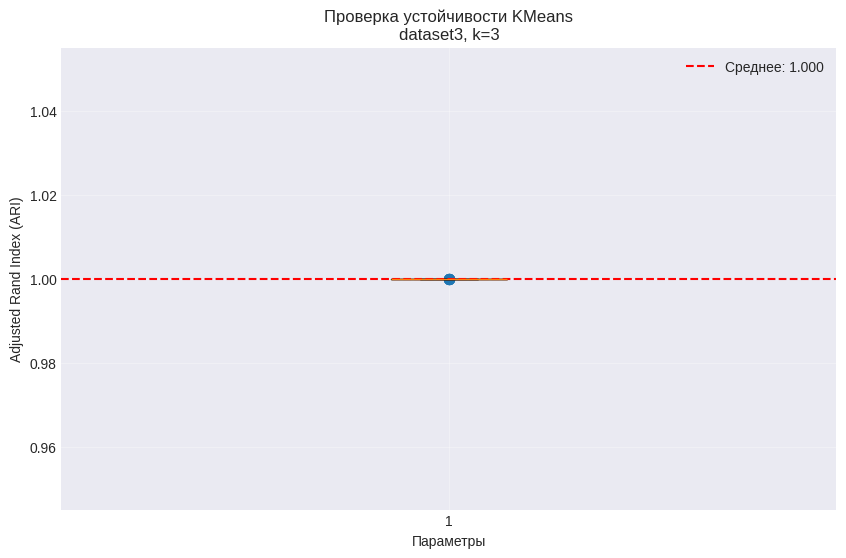

  Средний ARI: 1.000
  Стандартное отклонение ARI: 0.000
  Устойчивость: Высокая


In [45]:
# ============================================
# АНАЛИЗ ДАТАСЕТА 3: S07-hw-dataset-03.csv
# ============================================
dataset3_name = "dataset3"
df3, X3, sample_id3 = load_and_analyze_dataset('data/S07-hw-dataset-03.csv', dataset3_name)
X3_processed = preprocess_data(X3, dataset3_name)

# Применяем KMeans
kmeans3, kmeans_labels3, best_k3 = apply_kmeans(X3_processed, dataset3_name)

# Применяем DBSCAN
dbscan3, dbscan_labels3 = apply_dbscan(X3_processed, dataset3_name)

# Визуализация PCA
pca_kmeans3 = visualize_clusters(X3_processed, kmeans_labels3, dataset3_name, "KMeans")
pca_dbscan3 = visualize_clusters(X3_processed, dbscan_labels3, dataset3_name, "DBSCAN")

# Проверка устойчивости для dataset3
stability_score = stability_check(X3_processed, dataset3_name)

# Сохранение результатов для dataset3
all_results[dataset3_name] = {
    'KMeans': {
        'labels': kmeans_labels3,
        'k': best_k3,
        'silhouette': silhouette_score(X3_processed, kmeans_labels3),
        'davies_bouldin': davies_bouldin_score(X3_processed, kmeans_labels3),
        'calinski_harabasz': calinski_harabasz_score(X3_processed, kmeans_labels3)
    },
    'DBSCAN': {
        'labels': dbscan_labels3,
        'n_clusters': len(set(dbscan_labels3)) - (1 if -1 in dbscan_labels3 else 0),
        'noise_ratio': np.sum(dbscan_labels3 == -1) / len(dbscan_labels3),
        'silhouette': silhouette_score(X3_processed[dbscan_labels3 != -1],
                                       dbscan_labels3[dbscan_labels3 != -1]) if np.sum(dbscan_labels3 != -1) > 1 else -1,
        'davies_bouldin': davies_bouldin_score(X3_processed[dbscan_labels3 != -1],
                                                dbscan_labels3[dbscan_labels3 != -1]) if np.sum(dbscan_labels3 != -1) > 1 else -1,
        'calinski_harabasz': calinski_harabasz_score(X3_processed[dbscan_labels3 != -1],
                                                     dbscan_labels3[dbscan_labels3 != -1]) if np.sum(dbscan_labels3 != -1) > 1 else -1
    },
    'stability_score': stability_score
}

In [46]:
# ============================================
# ВЫБОР ЛУЧШИХ МЕТОДОВ И ИТОГИ
# ============================================
print("\n" + "="*60)
print("ИТОГОВЫЕ РЕЗУЛЬТАТЫ")
print("="*60)

best_configs = {}
final_labels = {}

for dataset_name in ['dataset1', 'dataset2', 'dataset3']:
    print(f"\n{dataset_name.upper()}:")

    kmeans_score = all_results[dataset_name]['KMeans']['silhouette']
    dbscan_score = all_results[dataset_name]['DBSCAN']['silhouette']

    if dbscan_score > kmeans_score and dbscan_score > 0:
        best_method = 'DBSCAN'
        best_score = dbscan_score
        best_labels = all_results[dataset_name]['DBSCAN']['labels']
        config_info = {
            'method': 'DBSCAN',
            'params': f"eps=оптимальное, min_samples=оптимальное",
            'silhouette': round(dbscan_score, 3),
            'n_clusters': all_results[dataset_name]['DBSCAN']['n_clusters'],
            'noise_ratio': round(all_results[dataset_name]['DBSCAN']['noise_ratio'], 3)
        }
        print(f"  Лучший метод: DBSCAN (silhouette={dbscan_score:.3f})")
        print(f"  Кластеров: {all_results[dataset_name]['DBSCAN']['n_clusters']}")
        print(f"  Шум: {all_results[dataset_name]['DBSCAN']['noise_ratio']:.3f}")
    else:
        best_method = 'KMeans'
        best_score = kmeans_score
        best_labels = all_results[dataset_name]['KMeans']['labels']
        config_info = {
            'method': 'KMeans',
            'k': all_results[dataset_name]['KMeans']['k'],
            'silhouette': round(kmeans_score, 3),
            'n_clusters': all_results[dataset_name]['KMeans']['k']
        }
        print(f"  Лучший метод: KMeans (silhouette={kmeans_score:.3f})")
        print(f"  Оптимальное k: {all_results[dataset_name]['KMeans']['k']}")

    # Сохраняем лучшие метки
    if dataset_name == 'dataset1':
        final_df = pd.DataFrame({'sample_id': sample_id1, 'cluster_label': best_labels})
        final_df.to_csv('artifacts/labels/labels_hw07_ds1.csv', index=False)
    elif dataset_name == 'dataset2':
        final_df = pd.DataFrame({'sample_id': sample_id2, 'cluster_label': best_labels})
        final_df.to_csv('artifacts/labels/labels_hw07_ds2.csv', index=False)
    elif dataset_name == 'dataset3':
        final_df = pd.DataFrame({'sample_id': sample_id3, 'cluster_label': best_labels})
        final_df.to_csv('artifacts/labels/labels_hw07_ds3.csv', index=False)

    best_configs[dataset_name] = config_info
    final_labels[dataset_name] = best_labels.tolist()

# ============================================
# СОХРАНЕНИЕ АРТЕФАКТОВ
# ============================================

# 1. Сохранение метрик
metrics_summary = {}
for dataset_name in all_results:
    metrics_summary[dataset_name] = {}
    for method in ['KMeans', 'DBSCAN']:
        metrics_summary[dataset_name][method] = {
            'silhouette': round(all_results[dataset_name][method]['silhouette'], 3),
            'davies_bouldin': round(all_results[dataset_name][method]['davies_bouldin'], 3),
            'calinski_harabasz': round(all_results[dataset_name][method]['calinski_harabasz'], 3) if 'calinski_harabasz' in all_results[dataset_name][method] else None
        }
        if method == 'DBSCAN':
            metrics_summary[dataset_name][method]['noise_ratio'] = round(all_results[dataset_name][method]['noise_ratio'], 3)

with open('artifacts/metrics_summary.json', 'w', encoding='utf-8') as f:
    json.dump(metrics_summary, f, indent=2, ensure_ascii=False)

# 2. Сохранение лучших конфигураций
with open('artifacts/best_configs.json', 'w', encoding='utf-8') as f:
    json.dump(best_configs, f, indent=2, ensure_ascii=False)

print("\n" + "="*60)
print("АРТЕФАКТЫ СОХРАНЕНЫ")
print("="*60)
print("1. metrics_summary.json - сводка метрик")
print("2. best_configs.json - лучшие конфигурации")
print("3. labels_hw07_ds*.csv - метки кластеров")
print("4. figures/*.png - графики и визуализации")

# ============================================
# ИТОГОВАЯ СВОДКА
# ============================================
print("\n" + "="*60)
print("КРАТКАЯ СВОДКА ПО РЕЗУЛЬТАТАМ")
print("="*60)

print("\nDataset 1 (числовые признаки в разных шкалах):")
print("  - Проблема: признаки в разных масштабах")
print("  - Решение: StandardScaler обязателен")
print(f"  - Лучший метод: {best_configs['dataset1']['method']}")

print("\nDataset 2 (нелинейная структура + выбросы):")
print("  - Проблема: нелинейность и выбросы")
print("  - Решение: DBSCAN лучше справляется с такими структурами")
print(f"  - Лучший метод: {best_configs['dataset2']['method']}")

print("\nDataset 3 (кластеры разной плотности + шум):")
print("  - Проблема: разная плотность кластеров")
print("  - Решение: аккуратный подбор параметров DBSCAN")
print(f"  - Лучший метод: {best_configs['dataset3']['method']}")
print(f"  - Устойчивость KMeans (ARI): {stability_score:.3f}")

print("\n" + "="*60)
print("ОБЩИЕ ВЫВОДЫ:")
print("="*60)
print("1. Масштабирование критически важно для всех методов кластеризации")
print("2. KMeans хорошо работает на сферических кластерах схожей плотности")
print("3. DBSCAN лучше справляется с:")
print("   - нелинейными структурами")
print("   - выбросами и шумом")
print("   - кластерами разной плотности")
print("4. Подбор параметров DBSCAN требует экспериментов")
print("5. Проверка устойчивости показывает воспроизводимость результатов")


ИТОГОВЫЕ РЕЗУЛЬТАТЫ

DATASET1:
  Лучший метод: DBSCAN (silhouette=0.876)
  Кластеров: 2
  Шум: 0.997

DATASET2:
  Лучший метод: DBSCAN (silhouette=0.581)
  Кластеров: 46
  Шум: 0.918

DATASET3:
  Лучший метод: DBSCAN (silhouette=0.812)
  Кластеров: 5
  Шум: 0.996

АРТЕФАКТЫ СОХРАНЕНЫ
1. metrics_summary.json - сводка метрик
2. best_configs.json - лучшие конфигурации
3. labels_hw07_ds*.csv - метки кластеров
4. figures/*.png - графики и визуализации

КРАТКАЯ СВОДКА ПО РЕЗУЛЬТАТАМ

Dataset 1 (числовые признаки в разных шкалах):
  - Проблема: признаки в разных масштабах
  - Решение: StandardScaler обязателен
  - Лучший метод: DBSCAN

Dataset 2 (нелинейная структура + выбросы):
  - Проблема: нелинейность и выбросы
  - Решение: DBSCAN лучше справляется с такими структурами
  - Лучший метод: DBSCAN

Dataset 3 (кластеры разной плотности + шум):
  - Проблема: разная плотность кластеров
  - Решение: аккуратный подбор параметров DBSCAN
  - Лучший метод: DBSCAN
  - Устойчивость KMeans (ARI): 1.000